In [1]:
import pandas as pd
import random
import numpy 
import csv

df = pd.read_csv("FOOD-DATA.csv")

df = df.iloc[:, 2:]

random.seed(10)

def classify(name: str) -> str:
    n = str(name).lower()
    if any(x in n for x in ["chicken", "beef", "pork", "meat", "ham", "turkey", "lamb", "sausage"]):
        return "meat"
    if any(x in n for x in ["fish", "tuna", "salmon", "sardine", "cod", "trout"]):
        return "fish"
    if any(x in n for x in ["milk", "cheese", "yog", "cream", "butter", "yoghurt"]):
        return "dairy"
    if any(x in n for x in ["banana", "apple", "orange", "fruit", "grape", "kiwi", "pear", "peach", "mango", "berry"]):
        return "fruit"
    if any(x in n for x in ["broccoli", "carrot", "lettuce", "vegetable", "tomato", "spinach", "pepper", "cabbage", "onion", "celery"]):
        return "veg"
    if any(x in n for x in ["rice", "bread", "couscous", "pasta", "corn", "cereal", "oat", "flour", "bagel", "cookie", "noodle"]):
        return "carb"
    if any(x in n for x in ["bean", "lentil", "chickpea", "pea"]):
        return "legume"
    if any(x in n for x in ["pizza", "soup", "mac", "hamburger", "hotdog", "lasagna", "stew"]):
        return "prepared"
    if any(x in n for x in ["chips", "snack", "cracker", "popcorn", "pretzel", "nacho"]):
        return "snack"
    if any(x in n for x in ["cake", "pie", "sweet", "muffin", "biscuit", "brownie"]):
        return "sweet"
    return "other"


df["Category"] = df["Name"].apply(classify)

# ========= ELIMINAR 50% DE CADA CATEGORÍA =========
df_filtered = (
    df.groupby("Category", group_keys=False)
      .apply(lambda x: x.sample(frac=0.4, random_state=10))   # 60 % de cada grupo
)

# ========= ASIGNAR PRECIOS =========
price_ranges = {
    "veg": (0.30, 1.00),
    "fruit": (0.40, 0.80),
    "carb": (0.20, 0.50),
    "legume": (0.20, 0.40),
    "dairy": (0.50, 1.40),
    "meat": (0.90, 2.00),
    "fish": (1.00, 2.40),
    "snack": (0.60, 1.30),
    "prepared": (0.60, 1.60),
    "sweet": (0.60, 1.40),
    "other": (0.50, 1.20),
}

def price(name: str) -> float:
    cat = classify(name)
    low, high = price_ranges[cat]
    return round(random.uniform(low, high), 2)

df_filtered["Price"] = df_filtered["Name"].apply(price)

df_filtered = df_filtered.drop(columns=["Category"])
df_filtered.to_csv("FOOD-DATA-PRICES.csv", index=False)

print("Dataset final guardado con", len(df_filtered), "alimentos")

Dataset final guardado con 959 alimentos


C:\Users\mvall\AppData\Local\Temp\ipykernel_9908\4170855935.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.4, random_state=10))   # 60 % de cada grupo


959 alimentos cargados.
gen	nevals	min        	avg       
0  	1000  	4.04235e+06	4.5391e+06
1  	858   	3.91831e+06	4.39244e+06

📌 Mejor valor energía: 3918311.5870000008
💰 Coste real: 4097.1500000000015

🔍 Nutrientes totales:
  Caloric Value: 870286.00  (mín 14000.0 – máx 17500.0)
  Fat: 36380.37  (mín 308.0 – máx 546.0)
  Saturated Fats: 16353.78  (mín 0.0 – máx 140.0)
  Monounsaturated Fats: 15642.45  (mín 70.0 – máx 245.0)
  Polyunsaturated Fats: 7250.66  (mín 35.0 – máx 175.0)
  Carbohydrates: 79139.33  (mín 910.0 – máx 2275.0)
  Sugars: 17135.02  (mín 0.0 – máx 350.0)
  Protein: 48712.76  (mín 350.0 – máx 840.0)
  Dietary Fiber: 9351.13  (mín 175.0 – máx 350.0)
  Cholesterol: 181567.37  (mín 0.0 – máx 2100.0)
  Sodium: 1176.69  (mín 0.0 – máx 16100.0)
  Water: 340524.44  (mín 14000.0 – máx 21000.0)
  Vitamin A: 5097.46  (mín 5.0 – máx 10.0)
  Vitamin B1: 710.67  (mín 5.0 – máx 20.0)
  Vitamin B11: 1950.03  (mín 2.0 – máx 10.0)
  Vitamin B12: 125.28  (mín 0.01 – máx 0.2)
  Vitamin 

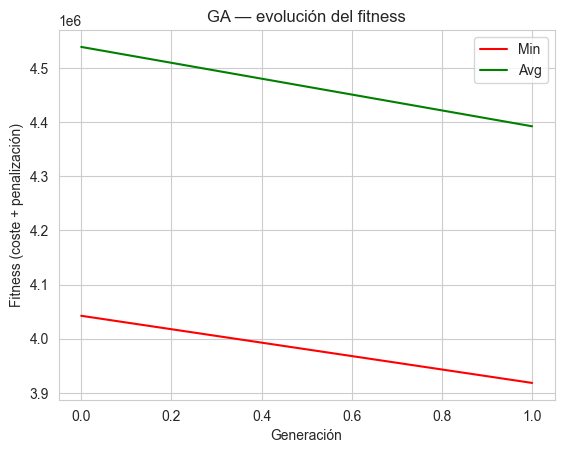

In [2]:
import random
import numpy 
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Parámetros del problema
# ==========================

CSV_FILE = "FOOD-DATA-PRICES.csv"
MAX_PORTION = 10          # porciones enteras permitidas

NUTRIENT_BOUNDS = {
    # Energía y macronutrientes (semana)
    "Caloric Value":        (14000.0, 17500.0),   # kcal/sem
    "Fat":                  (308.0, 546.0),       # g/sem
    "Saturated Fats":       (0.0,   140.0),       # g/sem
    "Monounsaturated Fats": (70.0, 245.0),        # g/sem
    "Polyunsaturated Fats": (35.0, 175.0),        # g/sem
    "Carbohydrates":        (910.0, 2275.0),      # g/sem
    "Sugars":               (0.0,   350.0),       # g/sem
    "Protein":              (350.0, 840.0),       # g/sem
    "Dietary Fiber":        (175.0, 350.0),       # g/sem
    "Cholesterol":          (0.0,   2100.0),      # mg/sem
    "Sodium":               (0.0,   16100.0),     # mg/sem
    "Water":                (14000.0, 21000.0),   # g/sem

    # Vitaminas (mg/semana)
    "Vitamin A":          (5.0,   10.0),        # mg/sem
    "Vitamin B1":         (5.0,   20.0),        # mg/sem
    "Vitamin B11":        (2.0,   10.0),        # mg/sem
    "Vitamin B12":        (0.01,  0.20),        # mg/sem
    "Vitamin B2":         (5.0,   20.0),        # mg/sem
    "Vitamin B3":         (80.0,  250.0),       # mg/sem
    "Vitamin B5":         (20.0,  100.0),       # mg/sem
    "Vitamin B6":         (7.0,   50.0),        # mg/sem
    "Vitamin C":          (400.0, 1500.0),      # mg/sem
    "Vitamin D":          (50.0,  200.0),       # mg/sem
    "Vitamin E":          (70.0,  300.0),       # mg/sem
    "Vitamin K":          (60.0,  250.0),       # mg/sem

    # Minerales (mg/semana)
    "Calcium":            (5600.0, 14000.0),    # mg/sem
    "Copper":             (4.2,   35.0),        # mg/sem
    "Iron":               (56.0,  315.0),       # mg/sem
    "Magnesium":          (2100.0, 3500.0),     # mg/sem
    "Manganese":          (10.5,  56.0),        # mg/sem
    "Phosphorus":         (3850.0, 14000.0),    # mg/sem
    "Potassium":          (21000.0, 35000.0),   # mg/sem
    "Selenium":           (30.0,  210.0),       # mg/sem
    "Zinc":               (56.0,  210.0),       # mg/sem

    # Métrica blanda (no se penaliza prácticamente)
    "Nutrition Density":  (0.0,   1e9)
}

POPULATION_SIZE = 1000
P_CROSSOVER = 0.8
P_MUTATION = 0.4
MAX_GENERATIONS = 1
HALL_OF_FAME_SIZE = 5

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

FOODS = None
NUTRIENT_NAMES = list(NUTRIENT_BOUNDS.keys())


# ==========================
# Utilidades
# ==========================

def load_foods(csv_file, nutrient_bounds):
    foods = []
    with open(csv_file, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            food = {"Name": row["Name"], "Price": float(row["Price"])}
            for nut in nutrient_bounds.keys():
                food[nut] = float(row[nut])
            foods.append(food)
    return foods

def init_portion():
    # 80 % de probabilidades de comenzar en 0–2
    # 20 % de probabilidades de comenzar en 3–MAX_PORTION
    if random.random() < 0.8:
        return random.randint(0, 3)
    else:
        return random.randint(4, MAX_PORTION)


# ==========================
# Fitness
# ==========================

def diet_fitness(individual):
    totals = {nut: 0.0 for nut in NUTRIENT_NAMES}

    cost = 0.0
    for qty, food in zip(individual, FOODS):
        cost += qty * food["Price"]
        for nut in NUTRIENT_NAMES:
            totals[nut] += qty * food[nut]

    penalty = 0.0
    for nut, (mn, mx) in NUTRIENT_BOUNDS.items():
        v = totals[nut]
        if v < mn:
            penalty += (mn - v)
        elif v > mx:
            penalty += (v - mx)

    # SOLO penalización, sin coste
    return (penalty,)


# ==========================
# Operadores GENÉTICOS → ENTEROS
# ==========================

def mutAddInteger(individual, indpb):
    """Suma/resta 1 unidad a un gen con probabilidad indpb."""
    for i in range(len(individual)):
        if random.random() < indpb:
            delta = random.choice([-1, 1])
            individual[i] = max(0, min(MAX_PORTION, individual[i] + delta))
    return individual,


# ==========================
# Main
# ==========================

def main():
    global FOODS
    FOODS = load_foods(CSV_FILE, NUTRIENT_BOUNDS)
    n_foods = len(FOODS)
    print(f"{n_foods} alimentos cargados.")

    toolbox.register("attrInt", random.randint, 0, MAX_PORTION)
    toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.attrInt, n_foods)
    toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

    toolbox.register("evaluate", diet_fitness)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("mate", tools.cxOnePoint)
    toolbox.register("mutate", mutAddInteger, indpb=1.0 / n_foods)

    population = toolbox.populationCreator(n=POPULATION_SIZE)
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", numpy.min)
    stats.register("avg", numpy.mean)

    population, logbook = algorithms.eaSimple(
        population,
        toolbox,
        cxpb=P_CROSSOVER,
        mutpb=P_MUTATION,
        ngen=MAX_GENERATIONS,
        stats=stats,
        halloffame=hof,
        verbose=True
    )

    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
    best = hof[0]

    cost = 0.0
    totals = {nut: 0.0 for nut in NUTRIENT_NAMES}
    for qty, food in zip(best, FOODS):
        cost += qty * food["Price"]
        for nut in NUTRIENT_NAMES:
            totals[nut] += qty * food[nut]

    print("\n📌 Mejor valor energía:", best.fitness.values[0])
    print("💰 Coste real:", cost)

    print("\n🔍 Nutrientes totales:")
    for nut, (mn, mx) in NUTRIENT_BOUNDS.items():
        print(f"  {nut}: {totals[nut]:.2f}  (mín {mn} – máx {mx})")

    print("\n🥗 Dieta obtenida:")
    for qty, food in zip(best, FOODS):
        if qty > 0:
            print(f"  {food['Name']}: {qty} porciones (100 g)")

    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red', label='Min')
    plt.plot(meanFitnessValues, color='green', label='Avg')
    plt.legend()
    plt.title("GA — evolución del fitness")
    plt.xlabel("Generación")
    plt.ylabel("Fitness (coste + penalización)")
    plt.show()


if __name__ == "__main__":
    main()

In [3]:
import csv
import pulp

# ========= Modelo LP =========
model = pulp.LpProblem("DietaFactibleEntera", pulp.LpStatusOptimal)

# Variable entera por alimento
x = {
    food["Name"]: pulp.LpVariable(food["Name"], lowBound=0, upBound=MAX_PORTION, cat="Integer")
    for food in FOODS
}

# Restricciones nutricionales
for nut, (mn, mx) in NUTRIENT_BOUNDS.items():
    total = pulp.lpSum(float(food[nut]) * x[food["Name"]] for food in FOODS)
    model += total >= mn
    model += total <= mx

# Objetivo arbitrario (solo resolver)
model += pulp.lpSum(x.values())

# Resolver
status = model.solve(pulp.PULP_CBC_CMD(msg=False))
print("\nEstado:", pulp.LpStatus[status])

if pulp.LpStatus[status] != "Optimal":
    print("\n❌ No existe solución factible con MAX_PORTION =", MAX_PORTION)
    quit()

print("\n✔ SOLUCIÓN FACTIBLE ENCONTRADA CON PORCIONES ENTERAS (100 g)\n")

# ========= Mostrar alimentos usados =========
selected = {food["Name"]: int(x[food["Name"]].value()) for food in FOODS if x[food["Name"]].value() > 0}
for food, qty in selected.items():
    print(f"{food}: {qty} porciones")

# ========= Calcular nutrientes totales =========
totals = {nut: 0.0 for nut in NUTRIENT_BOUNDS}
for food in FOODS:
    qty = int(x[food["Name"]].value())
    if qty > 0:
        for nut in NUTRIENT_BOUNDS:
            totals[nut] += float(food[nut]) * qty

print("\n🔍 Nutrientes totales:")
for nut, (mn, mx) in NUTRIENT_BOUNDS.items():
    v = totals[nut]
    print(f"  {nut}: {v:.2f}  (mín {mn} – máx {mx})")


Estado: Optimal

✔ SOLUCIÓN FACTIBLE ENCONTRADA CON PORCIONES ENTERAS (100 g)

fried rice: 10 porciones
popcorn oil popped: 1 porciones
raisin cookies: 10 porciones
cheese soup: 5 porciones
fish broth: 1 porciones
fish sticks: 1 porciones
peach nectar: 1 porciones
chicken stock: 10 porciones
mustard greens cooked: 10 porciones
palm kernel oil: 10 porciones
tartar sauce: 10 porciones
turnip greens canned: 6 porciones
bulgur cooked: 1 porciones
prune plums canned: 1 porciones
catsup: 1 porciones
margarine: 2 porciones
collard cooked: 10 porciones
radicchio: 10 porciones
table water: 3 porciones
beet greens cooked: 8 porciones
hominy canned: 1 porciones
amaranth leaves: 10 porciones
dandelion greens cooked: 10 porciones
nachos taco bell: 1 porciones
soft pretzels: 10 porciones
japanese cabbage: 5 porciones
vegetable oil: 10 porciones

🔍 Nutrientes totales:
  Caloric Value: 14002.00  (mín 14000.0 – máx 17500.0)
  Fat: 466.09  (mín 308.0 – máx 546.0)
  Saturated Fats: 139.89  (mín 0.0 – má